# ベイズ学習に入門した話
なつお @natsuokw

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 線形回帰

### 線形回帰の流れ
1. 基底関数 $\phi(x)$を決める  
2. $y(\boldsymbol{\phi}(x), \boldsymbol{\theta})$ の誤差関数 $E(\boldsymbol{\theta})$ を設定する  
3. 誤差関数 $E(\boldsymbol{\theta})$ を最小化する $\boldsymbol{\theta}^*$ を求める

### データの準備

以下の関数から10点サンプルを取る。

$$
y = sin(5x) + 0.1x
$$

入力を $\boldsymbol{X} = (x_1, … , x_n)$、出力を $\boldsymbol{t} = (t_1, …, t_n)$ とする。

In [2]:
def y(x):
    return np.sin(x * 5) + 0.1 * x

In [3]:
# X = np.array([ np.random.rand() for i in range(10)])
X = np.array([0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443, 0.63992102, 0.29335329, 0.94466892, 0.52184832, 0.41466194])

In [4]:
# ノイズを加えて t を生成
t = np.array([y(x) + (np.random.rand() - 0.5) / 4 for x  in X])

真の分布に重ねてプロット

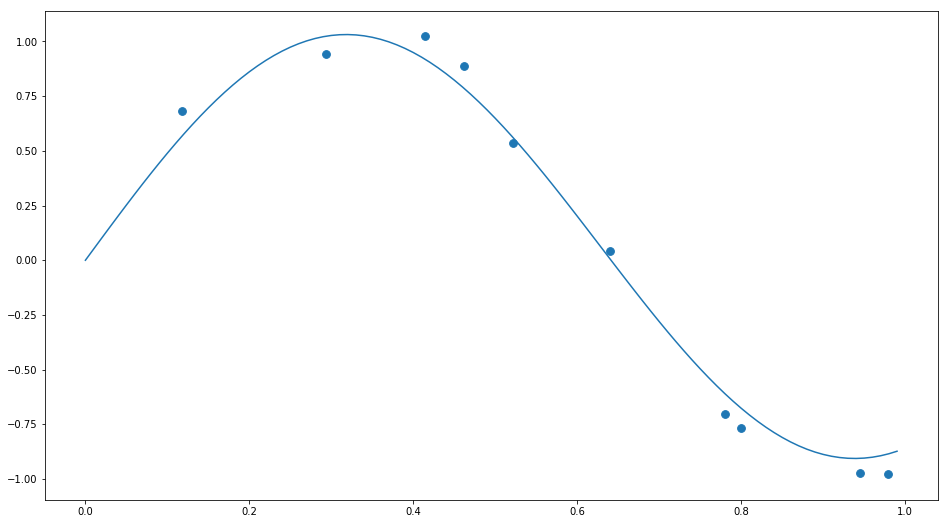

In [5]:
xlist = np.arange(0, 1, 0.01)
y_truth = np.sin(xlist * 5)  + 0.1 * xlist
plt.figure(figsize=(16, 9))
plt.plot(xlist, y_truth)
plt.scatter(X, t, s=60)
plt.show()

基底関数を $\boldsymbol{\phi}(x) = (1, x, x^2, x^3)$ とすると

$$
y(x, \boldsymbol{w}) = \boldsymbol{w}^T\boldsymbol{\phi}(x) = w_0 + w_1x + w_2x^2 + w_3x^3
$$

誤差関数は
$$
E(\boldsymbol{w}) = \sum_{i=1}^{N}\{\boldsymbol{w}^T\boldsymbol{\phi}(x_n) - t_n\}^2
$$
となる。これを最小化する。

$E(\boldsymbol{w})$ を $\boldsymbol{w}$  について微分して0と置いたものを $\boldsymbol{w}$ について解くと、以下の式が得られる。  
（正規方程式）

$$
\boldsymbol{w}^* = (\Phi^T\Phi)^{-1}\Phi^T\boldsymbol{t}
$$

ただし

$$
\Phi=\left[
\begin{array}{ccc}
\phi_0(x_1) & \phi_1(x_1) & \cdots　 & \phi_{M-1}(x_1) \\
\phi_0(x_2) & \phi_1(x_1) & \cdots　 & \phi_{M-1}(x_1) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(x_1) & \phi_1(x_1) & \cdots　 & \phi_{M-1}(x_1)\\
\end{array}
\right]
$$

正規方程式
$$
\boldsymbol{w}^* = (\Phi^T\Phi)^{-1}\Phi^T\boldsymbol{t}
$$
を解く

In [6]:
def phi(x):
    return [x ** i for i in range(4)]

PHI = np.array([phi(x) for x in X])
w = np.dot(np.linalg.inv(np.dot(PHI.T, PHI)), np.dot(PHI.T, t))
w

array([ -0.45725359,  12.21275574, -27.37350001,  14.64738404])

Scikit-learn でも同じ答えになるかテスト

In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(PHI, t)
reg.coef_

array([ -0.45725359,  12.21275574, -27.37350001,  14.64738404])

### 学習結果

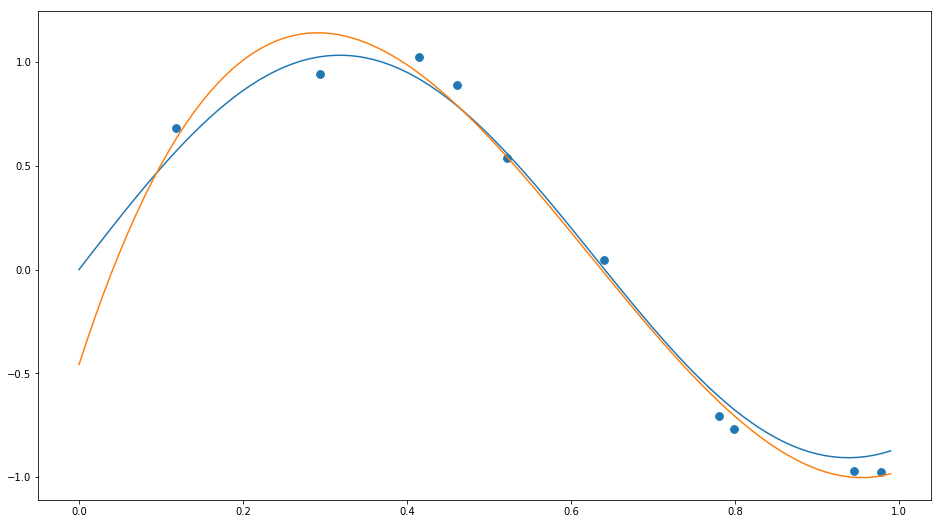

In [8]:
xlist = np.arange(0, 1.0, 0.01)
y_truth = y(xlist)
y_pred = np.dot(w, np.array(phi(xlist)))

plt.figure(figsize=(16, 9))
plt.plot(xlist, y_truth)
plt.scatter(X, t, s=60)
plt.plot(xlist, y_pred)
plt.show()

# ベイズ線形回帰

### ベイズ学習の流れ
1. パラメータ $\boldsymbol{\theta}$ の事前分布 $p(\boldsymbol{\theta})$ を仮定
2. 観測データを使って事後分布 $p(\boldsymbol{\theta}|\boldsymbol{x}, \boldsymbol{t})$ を求める
3. 事後分布を使って予測分布 $p(t|\boldsymbol{x},\boldsymbol{t})$ を求める

通常の線形回帰では確定的な値として求めていたパラメータ $\boldsymbol{w}$ を確率的に取り扱う。  
$\boldsymbol{w}$ の事前分布を、平均 $\boldsymbol{m}_0$、分散 $\boldsymbol{S}_0$ のガウス分布に従うと仮定する。  すなわち

$$
p(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w}\ |\ \boldsymbol{m}_0, \boldsymbol{S}_0) 
$$

と書けるとする。ここでは簡単のため期待値 $ \boldsymbol{0} $ 分散 $ \alpha^{-1}\boldsymbol{I} $ とする。

つまり次のように書ける。

$$
p(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w}\ |\ \boldsymbol{0}, \alpha^{-1}\boldsymbol{I}) 
$$

事後分布はベイズの定理から
$$
p(\boldsymbol{w}|\boldsymbol{t}) = \frac{p(\boldsymbol{t}|\boldsymbol{w})p(\boldsymbol{w})}{p(\boldsymbol{t})} = \frac{p(\boldsymbol{t}|\boldsymbol{w})p(\boldsymbol{w})}{\int_{ - \infty }^{ \infty } p(\boldsymbol{t}|\boldsymbol{w})p(\boldsymbol{w})d\boldsymbol{w}}
$$

これを解くと

$$
p(\boldsymbol{w}|\boldsymbol{t}) = \mathcal{N}(\boldsymbol{w}\ |\ \boldsymbol{m}_N, \boldsymbol{S}_N) 
$$

となる。ただし

$$
\begin{eqnarray}
\boldsymbol{m}_N &=& \beta\boldsymbol{S}_N\Phi^T\boldsymbol{t} \\
{\boldsymbol{S}_N}^{-1} &=&\alpha\boldsymbol{I} + \beta\Phi^T\Phi
\end{eqnarray}
$$

$\alpha=0.01$、$\beta=10$ として
$$
\begin{eqnarray}
{\boldsymbol{S}_N}^{-1} &=&\alpha\boldsymbol{I} + \beta\Phi^T\Phi \\
\boldsymbol{m}_N &=& \beta\boldsymbol{S}_N\Phi^T\boldsymbol{t}
\end{eqnarray}
$$
を計算する。

In [9]:
alpha = 0.01
beta = 10

S_N = np.linalg.inv(alpha * np.identity(PHI.shape[1]) + beta * np.dot(PHI.T, PHI))
m_N = beta * np.dot(S_N, np.dot(PHI.T, t))

In [10]:
S_N

array([[  0.27238552,  -1.4476992 ,   2.28490206,  -1.11418544],
       [ -1.4476992 ,  10.1209756 , -19.03977812,  10.52433226],
       [  2.28490206, -19.03977812,  40.14072815, -23.9715653 ],
       [ -1.11418544,  10.52433226, -23.9715653 ,  15.06766114]])

In [11]:
m_N

array([  0.50945255,   4.21669302, -10.53864117,   4.58810378])

In [12]:
def gaussian_distribution_function(x, mean, var): 
    return np.exp(-(x-mean) ** 2 / (2 * var)) / np.sqrt(2 * np.pi * var)

予測分布は

$$
p(t|\boldsymbol{x}, \boldsymbol{t}, \alpha, \beta) = \displaystyle \int_{ - \infty }^{ \infty } p(t|\boldsymbol{w},\boldsymbol{x})p(\boldsymbol{w}|\boldsymbol{t}) d\boldsymbol{w}
$$

と定義される。

これを変形して

$$
p(t|\boldsymbol{x}, \boldsymbol{t}, \alpha, \beta) = \mathcal{N}(t|\boldsymbol{m}_N^T\boldsymbol{\phi}(\boldsymbol{x}), \frac{1}{\beta} + \boldsymbol{\phi}(\boldsymbol{x})^T\boldsymbol{S}_N\boldsymbol{\phi}(\boldsymbol{x}))
$$

を得る。

$x = 0.3$ としたときの $y$ の分布をプロット  

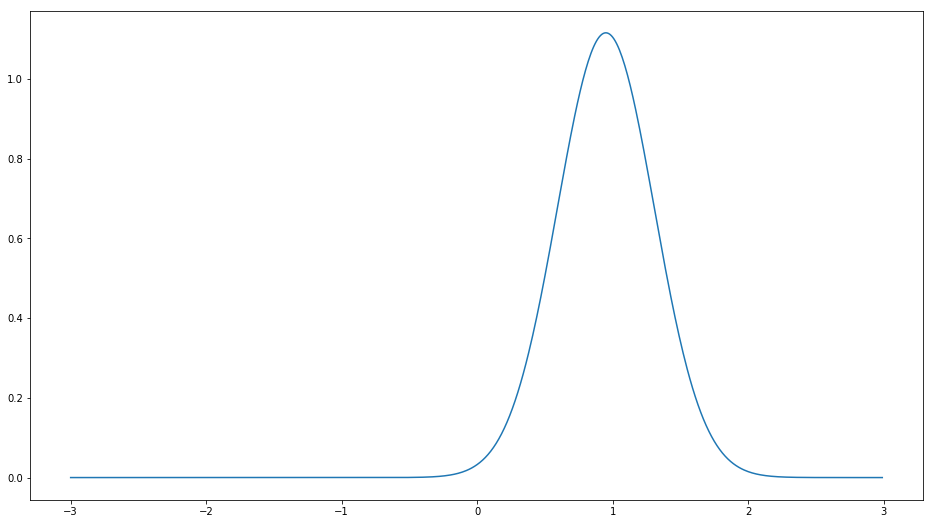

In [13]:
x_test = 0.3
y_test = np.arange(-3, 3, 0.01)
m_test = np.dot(m_N, phi(x_test))
S_test = 1 / beta + np.dot(phi(x_test), np.dot(S_N, phi(x_test)))

dist = gaussian_distribution_function(y_test, m_test, S_test)

plt.figure(figsize=(16, 9))
plt.plot(y_test, dist)
plt.show()

$x$ を動かして $y$ の確率の変化を見る

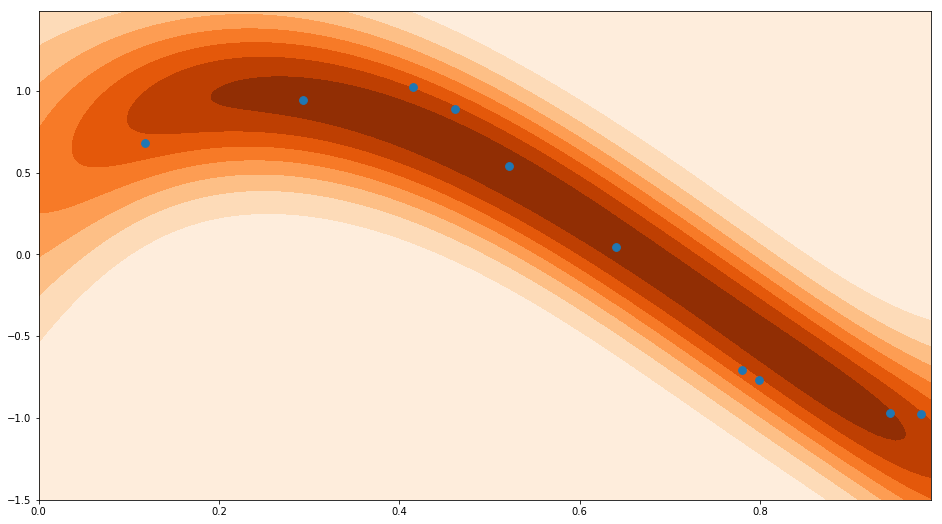

In [14]:
xlist = np.arange(0, 1.0, 0.01)
tlist = np.arange(-1.5, 1.5, 0.01)

# mean = np.dot(m_N, phi(x))
# var     = 1 / beta + np.dot(phi(x), np.dot(S_N, phi(x)))
zlist = np.array([gaussian_distribution_function(tlist, np.dot(m_N, phi(x)), 1 / beta + np.dot(phi(x), np.dot(S_N, phi(x)))) for x in xlist]).T

plt.figure(figsize=(16, 9))
plt.contourf(xlist, tlist, zlist, 10, cmap=plt.cm.Oranges)
plt.scatter(X, t, s=60)
plt.show()

### まとめ
#### 線形回帰
- 基底関数を決定 → 誤差関数を定義 → 誤差関数を最小化するパラメータを探索
- 入力 $x$ に対する $t$ の値が得られる

#### ベイズ
- パラメータの事前分布を仮定 → 事後分布を推定 → 予測分布を導出
- 入力 $x$ に対する $t$ の分布が得られる